In [114]:
from itertools import product
import warnings
import datetime
from dateutil.relativedelta import relativedelta

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from scipy import stats

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

%matplotlib inline

In [47]:
data = pd.read_csv('WAG_C_M.csv', sep=';', skiprows=1, 
                   index_col=0, parse_dates=['month'],
                   dayfirst=True, names=['month', 'salary'])

Критерий Дики-Фуллера: p=0.991850


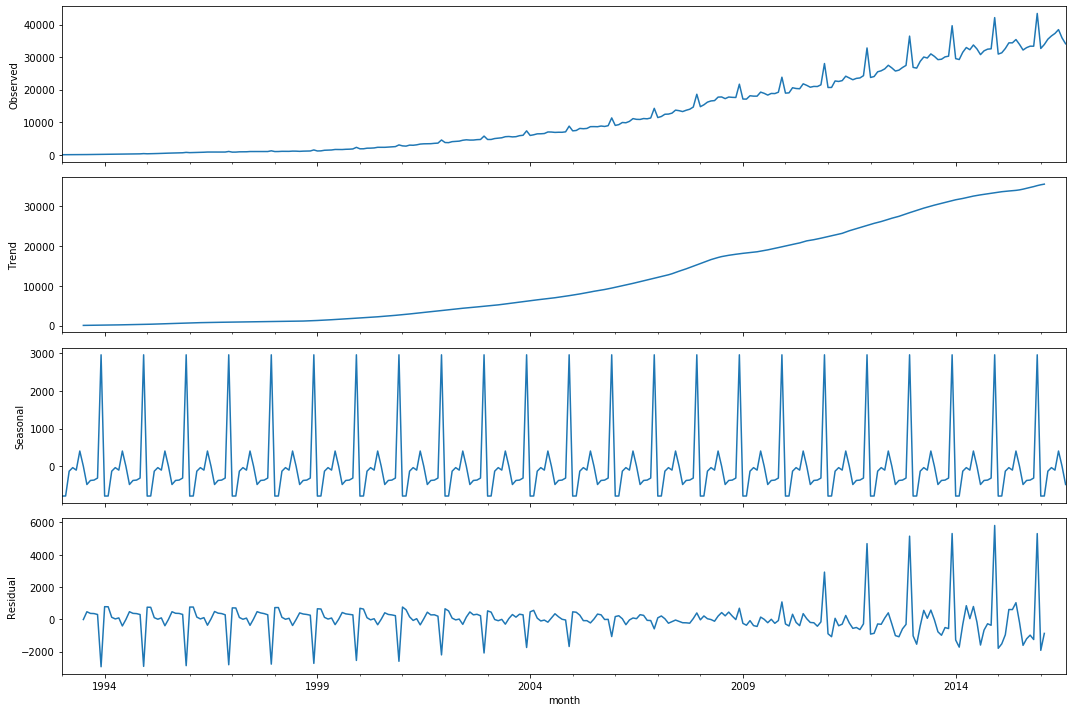

In [48]:
rcParams['figure.figsize'] = 15, 10
sm.tsa.seasonal_decompose(data['salary']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary'])[1])

#### Стабилизация диспресии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


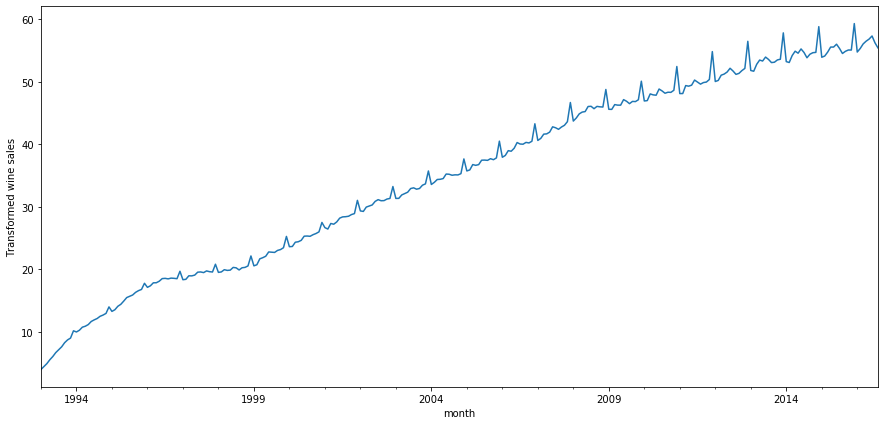

In [52]:
data['salary_box'], lmbda = stats.boxcox(data['salary'])
plt.figure(figsize=(15,7))
data['salary_box'].plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box'])[1])

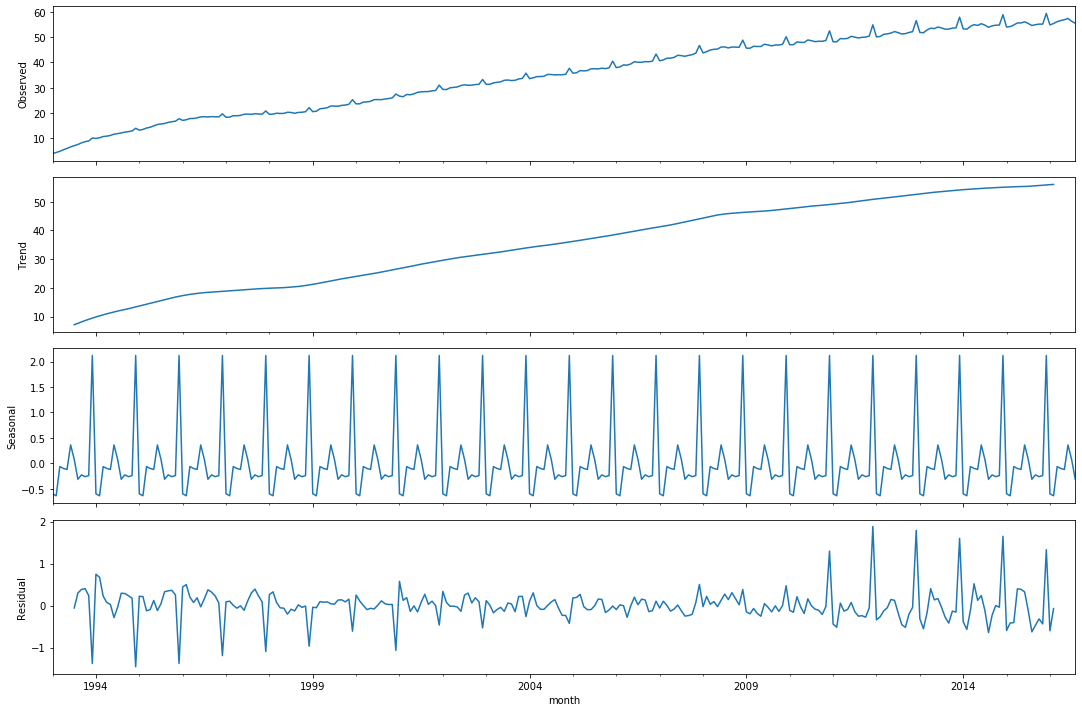

In [54]:
rcParams['figure.figsize'] = 15, 10
sm.tsa.seasonal_decompose(data['salary_box']).plot();

#### Дифференцирование

In [64]:
data['salary_box_diff'] = data['salary_box'] - data['salary_box'].shift(12)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['salary_box_diff'].dropna())[1])

Критерий Дики-Фуллера: p=0.014697


#### Подбор q, Q

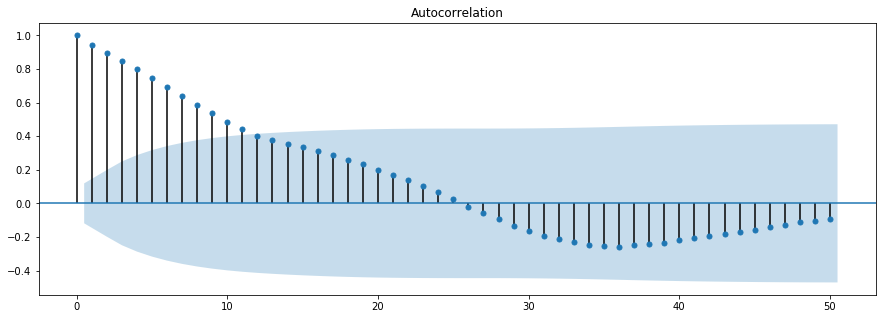

In [76]:
rcParams['figure.figsize'] = 15, 5
sm.graphics.tsa.plot_acf(data['salary_box_diff'].dropna().values, lags=50);

Нет значимых сезонных лагов: Q=0
<br>
Последний значимый лаг равен 11: q=11

#### Подбор p, P

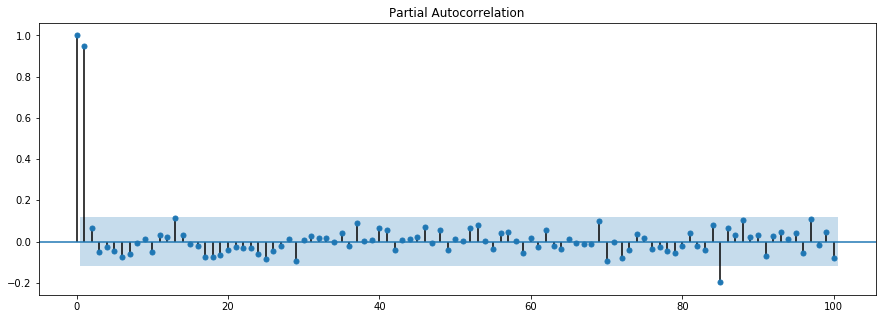

In [79]:
rcParams['figure.figsize'] = 15, 5
sm.graphics.tsa.plot_pacf(data['salary_box_diff'].dropna().values, lags=100);

Нет значимых сезонных лагов: P=0
<br>
Последний значимый лаг равен 1: p=1

#### Выбор модели

In [87]:
ps = range(0, 2)
d = 0
qs = range(0, 12)
P = 0
D = 1
Q = 0

In [88]:
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [89]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['salary_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(P, D, Q, 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1min 22s, sys: 725 ms, total: 1min 23s
Wall time: 21.7 s


In [94]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head(10)

,parameters,aic
21,"(1, 9)",-7.882551
22,"(1, 10)",-6.808521
23,"(1, 11)",-5.127472
20,"(1, 8)",-4.342942
19,"(1, 7)",-2.680367
18,"(1, 6)",-2.650123
17,"(1, 5)",1.886630
16,"(1, 4)",8.232175
15,"(1, 3)",9.436359
14,"(1, 2)",9.558622


In [95]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 0, 9)x(0, 1, 0, 12)   Log Likelihood                  14.941
Date:                            Sun, 29 Mar 2020   AIC                             -7.883
Time:                                    14:51:58   BIC                             31.781
Sample:                                01-01-1993   HQIC                             8.041
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9892      0.007    138.818      0.000       0.975       1.003
ma.L1         -0.1901      0.049   

Критерий Стьюдента: p=0.982448
Критерий Дики-Фуллера: p=0.000000


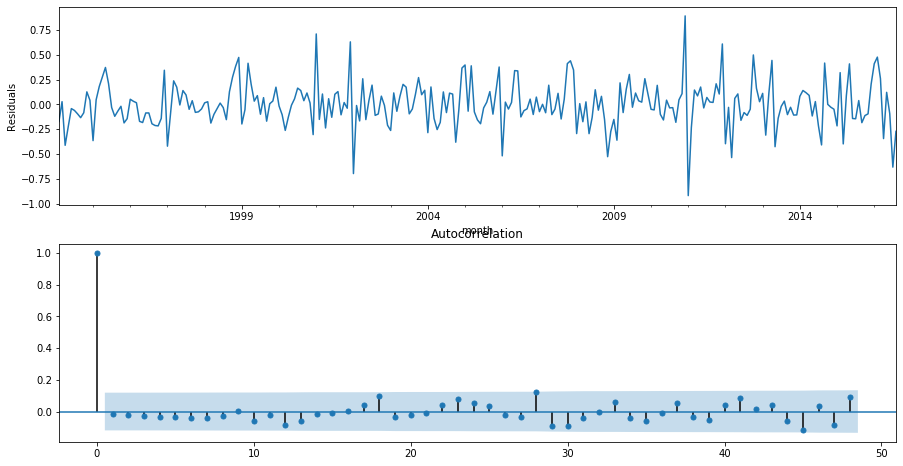

In [102]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

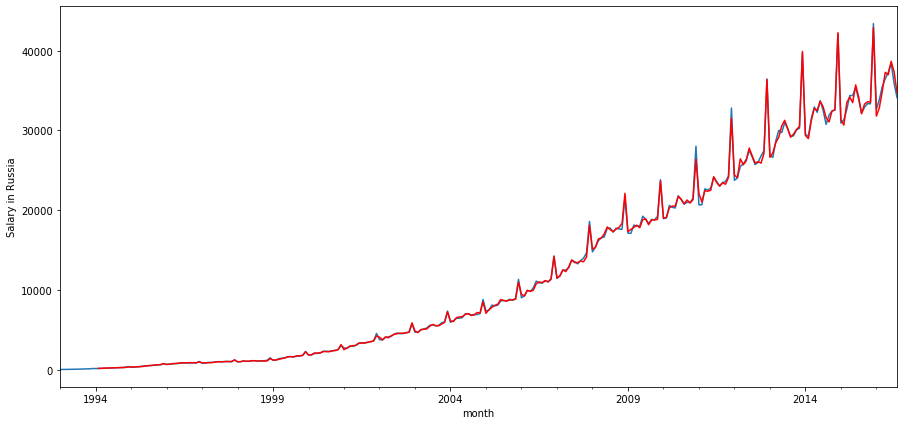

In [106]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
data['salary'].plot()
data.model[13:].plot(color='r')
plt.ylabel('Salary in Russia')
plt.show()
# pylab.show()

#### Прогноз

In [109]:
data.shape[0]

284

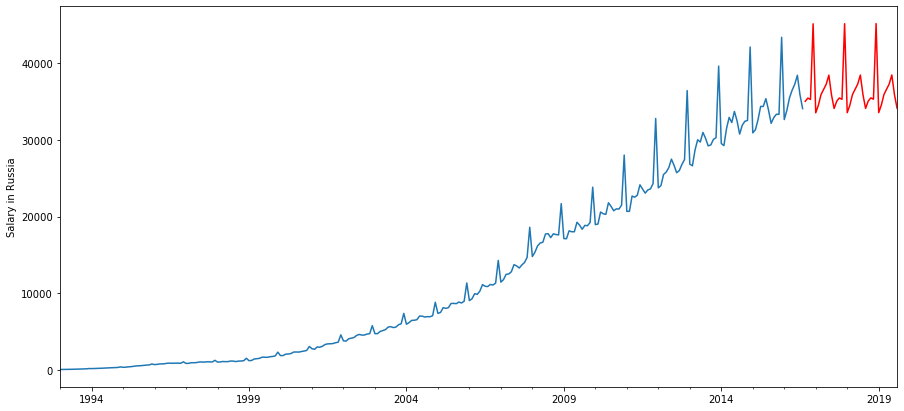

In [128]:
data2 = data[['salary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=data.shape[0]+35), lmbda)

plt.figure(figsize=(15,7))
data2['salary'].plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary in Russia')
plt.show()